# Test PDPbox with Regression problem
## Kaggle Rossmann store with RandomForest regressor
This demo is based on **Rossmann Store Sales**  
https://www.kaggle.com/c/rossmann-store-sales

In [1]:
import pandas as pd
from pdpbox import pdp, get_dataset, info_plots

# versions
- `matplotlib`: 3.1.1
- `sklearn`: 0.23.1

In [2]:
import matplotlib
print(matplotlib.__version__)

3.1.1


In [3]:
import sklearn
print(sklearn.__version__)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

0.23.1


# train a simple RandomForestRegressor
We assume there is a `rossmann-store-sales` data folder under the same directory. The dataset is directly downloaded from kaggle with command `kaggle competitions download -c rossmann-store-sales`.

In [4]:
! ls rossmann-store-sales/

sample_submission.csv  store.csv  test.csv  train.csv


In [5]:
train_df = pd.read_csv('rossmann-store-sales/train.csv')
store_df = pd.read_csv('rossmann-store-sales/store.csv')
print(train_df.shape, store_df.shape)

(1017209, 9) (1115, 10)


In [6]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
train_df = train_df.merge(store_df, on='Store', how='left')
print(train_df.shape)

(1017209, 18)


## simple feature engineering

In [9]:
ross_data = train_df.copy()
ross_data['Date'] = pd.to_datetime(ross_data['Date'])
ross_data['month'] = ross_data['Date'].dt.month
ross_data['weekofyear'] = ross_data['Date'].dt.weekofyear

uni_values = {
    'StateHoliday': ['a', 'b', 'c'],
    'StoreType': ['a', 'b', 'c', 'd'],
    'Assortment': ['a', 'b', 'c']
}

for col in uni_values:
    for value in uni_values[col]:
        ross_data['{}_{}'.format(col, value)] = (ross_data[col] == value).map(int)

In [10]:
features = [
    'DayOfWeek', 'SchoolHoliday', 'month', 'weekofyear', 
    'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 
    'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 
    'Assortment_a', 'Assortment_b', 'Assortment_c'
]
target = 'Sales'
X_train, X_test, y_train, y_test = train_test_split(
    ross_data[features], ross_data[target], test_size = 0.2, random_state=42)

In [11]:
%%time
regressor = RandomForestRegressor(
    n_estimators=50, 
    criterion='mse',
    n_jobs=4,
    random_state=42
)
regressor.fit(X_train, y_train)

CPU times: user 1min 21s, sys: 139 ms, total: 1min 21s
Wall time: 21.1 s


In [12]:
regressor.score(X_test, y_test)

0.588290073797243

In [13]:
ross_features = features
ross_model = regressor
ross_target = target

# [for internal usage] dump to `.pkl` for unit test

# or you can directory load the data and model

In [4]:
test_ross = get_dataset.ross()
test_ross.keys()

dict_keys(['data', 'features', 'target', 'rf_model'])

In [5]:
ross_data = test_ross['data']
ross_features = test_ross['features']
ross_model = test_ross['rf_model']
ross_target = test_ross['target']

In [6]:
ross_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,0,0,0,0,1,0,1,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,0,0,0,1,0,0,0,1,0,0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,0,0,0,1,0,0,0,1,0,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0,0,0,0,0,1,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0,0,0,1,0,0,0,1,0,0


# 1. Binary feature: SchoolHoliday

## 1.1 target distribution through feature 'SchoolHoliday'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


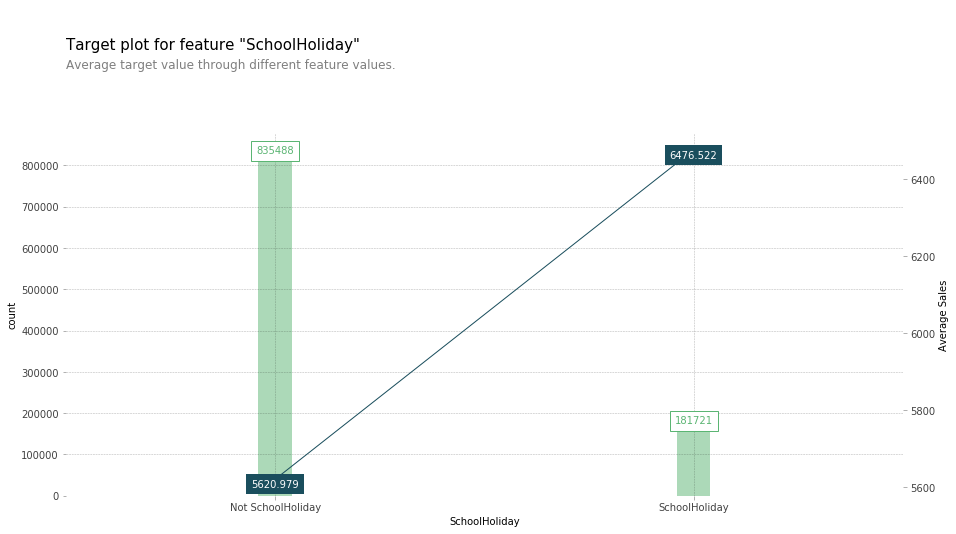

In [7]:
fig, axes, summary_df = info_plots.target_plot(
    df=ross_data, feature='SchoolHoliday', feature_name='SchoolHoliday', target=ross_target
)
_ = axes['bar_ax'].set_xticklabels(['Not SchoolHoliday', 'SchoolHoliday'])

In [8]:
summary_df

,x,display_column,count,Sales
0,0,SchoolHoliday_0,835488,5620.979034
1,1,SchoolHoliday_1,181721,6476.522207


## 1.2 check prediction distribution through feature 'SchoolHoliday'

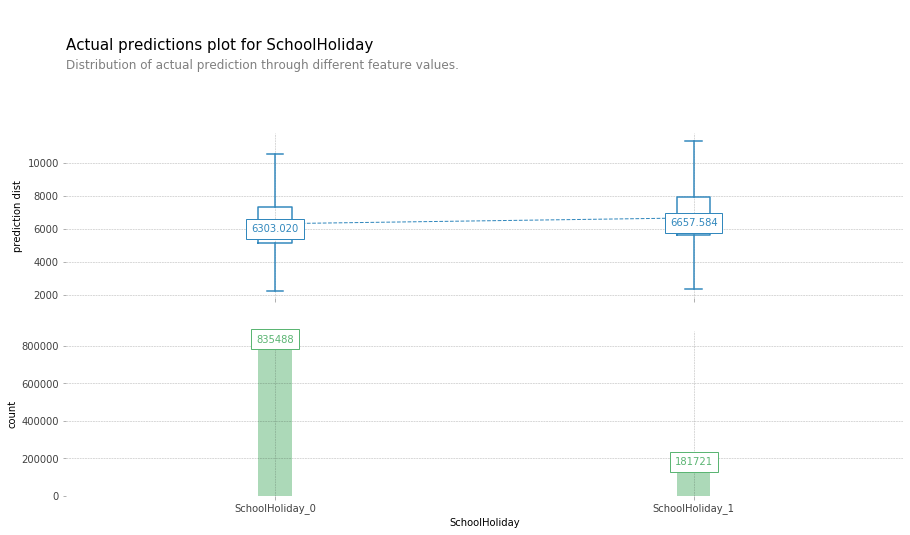

In [9]:
fig, axes, summary_df = info_plots.actual_plot(
    model=ross_model, X=ross_data[ross_features], feature='SchoolHoliday', feature_name='SchoolHoliday'
)

In [10]:
summary_df

,x,display_column,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,SchoolHoliday_0,835488,5139.344190,6303.019681,7297.954991
1,1,SchoolHoliday_1,181721,5641.174245,6657.583982,7914.100138


## 1.3 pdp for feature 'SchoolHoliday'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


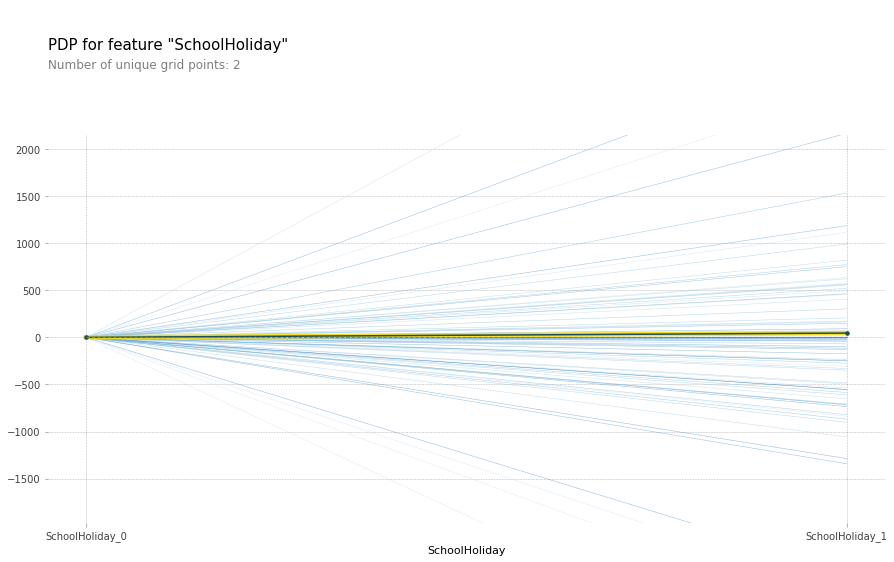

In [11]:
pdp_SchoolHoliday = pdp.pdp_isolate(
    model=ross_model, dataset=ross_data, model_features=ross_features, feature='SchoolHoliday'
)
fig, axes = pdp.pdp_plot(pdp_SchoolHoliday, 'SchoolHoliday', plot_lines=True, frac_to_plot=100)

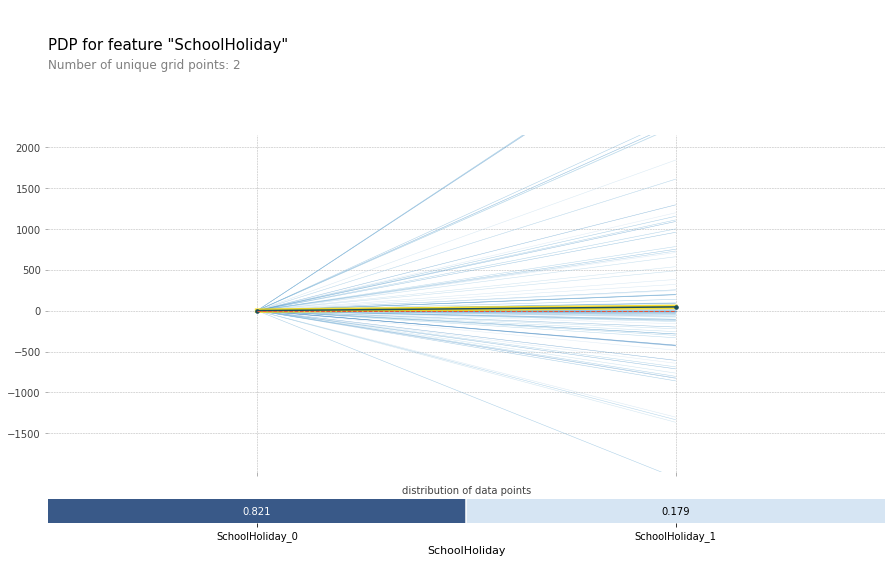

In [12]:
fig, axes = pdp.pdp_plot(pdp_SchoolHoliday, 'SchoolHoliday', plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

# 2. one-hot encoding feature: StoreType

## 2.1 target distribution through feature 'StoreType'

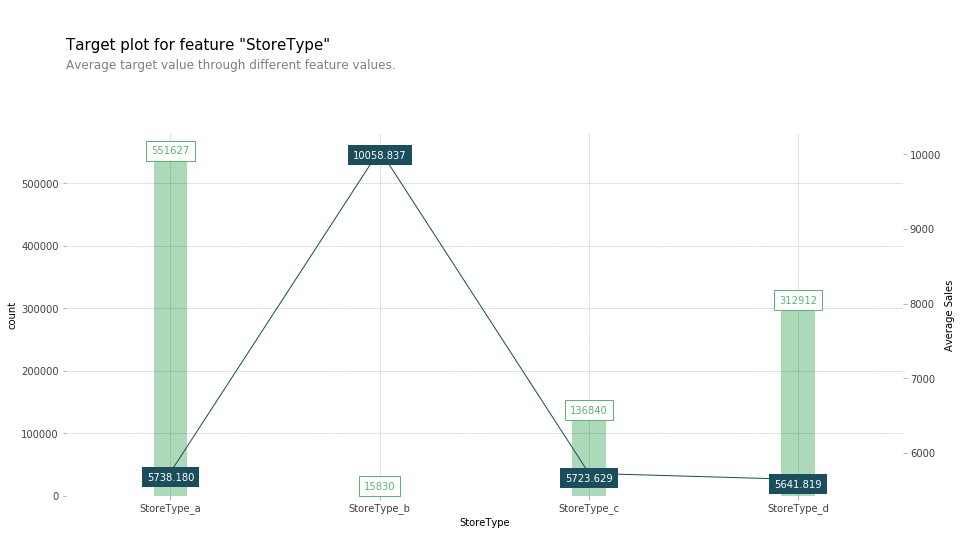

In [13]:
fig, axes, summary_df = info_plots.target_plot(
    df=ross_data, feature=['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d'], 
    feature_name='StoreType', target=ross_target
)

In [14]:
summary_df

,x,display_column,count,Sales
0,0,StoreType_a,551627,5738.179710
1,1,StoreType_b,15830,10058.837334
2,2,StoreType_c,136840,5723.629246
3,3,StoreType_d,312912,5641.819243


## 2.2 check prediction distribution through feature 'StoreType'

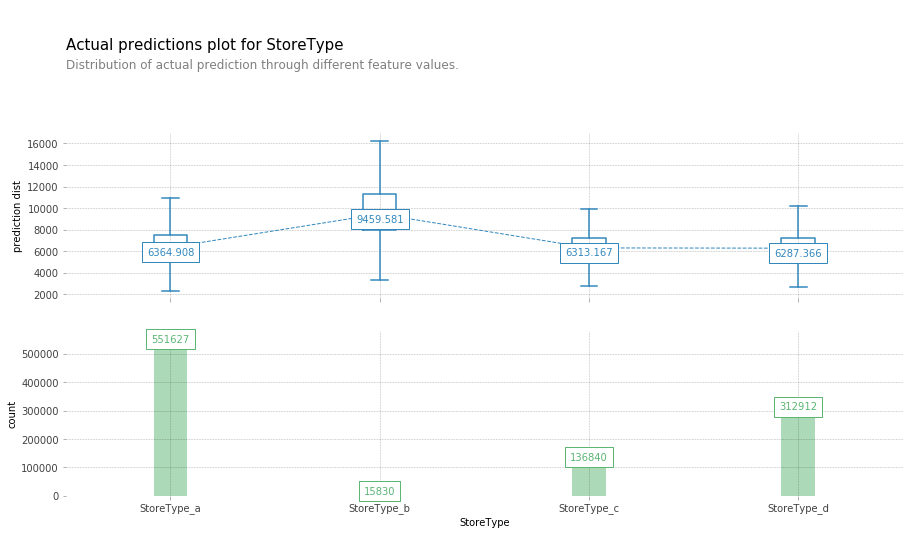

In [15]:
fig, axes, summary_df = info_plots.actual_plot(
    model=ross_model, X=ross_data[ross_features], 
    feature=['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d'], feature_name='StoreType'
)

In [16]:
summary_df

,x,display_column,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,StoreType_a,551627,5130.837253,6364.908030,7474.793464
1,1,StoreType_b,15830,7954.609484,9459.581491,11269.024415
2,2,StoreType_c,136840,5435.473246,6313.167140,7247.301128
3,3,StoreType_d,312912,5294.680040,6287.366274,7259.189361


## 2.3 pdp for feature 'StoreType'

CPU times: user 14.9 s, sys: 494 ms, total: 15.4 s
Wall time: 5.24 s


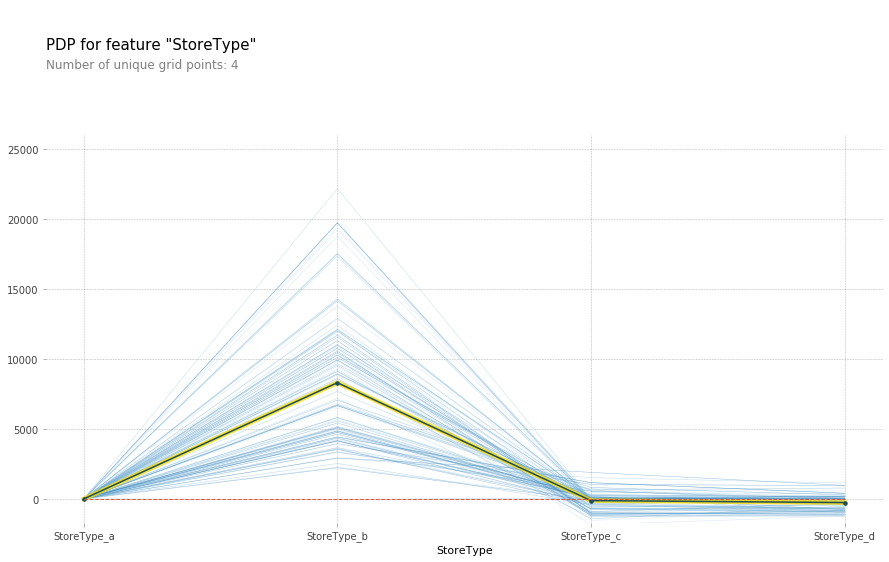

In [17]:
%%time
pdp_StoreType = pdp.pdp_isolate(
    model=ross_model, dataset=ross_data, model_features=ross_features, 
    feature=['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']
)
fig, axes = pdp.pdp_plot(pdp_StoreType, 'StoreType', plot_lines=True, frac_to_plot=100)

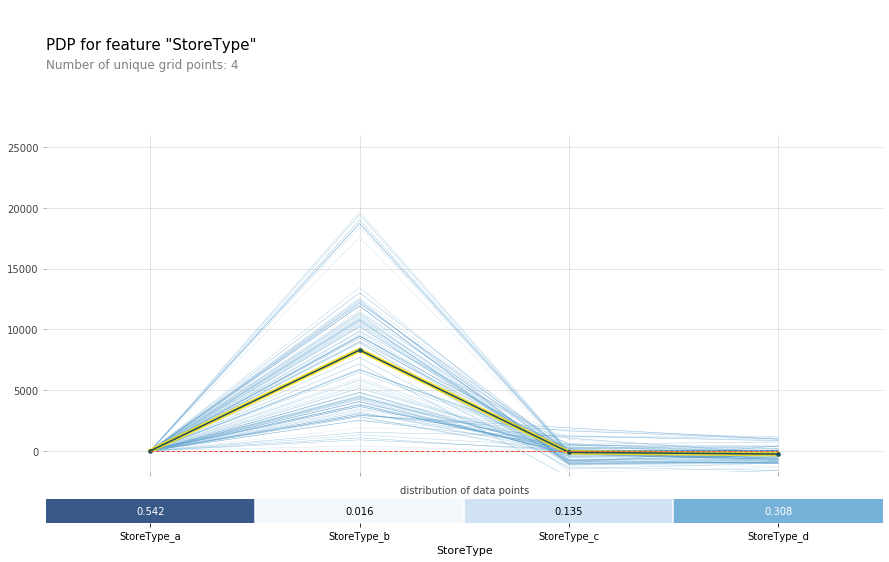

In [18]:
fig, axes = pdp.pdp_plot(pdp_StoreType, 'StoreType', plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

# 3. numeric feature: weekofyear

## 3.1 target distribution through feature 'weekofyear'

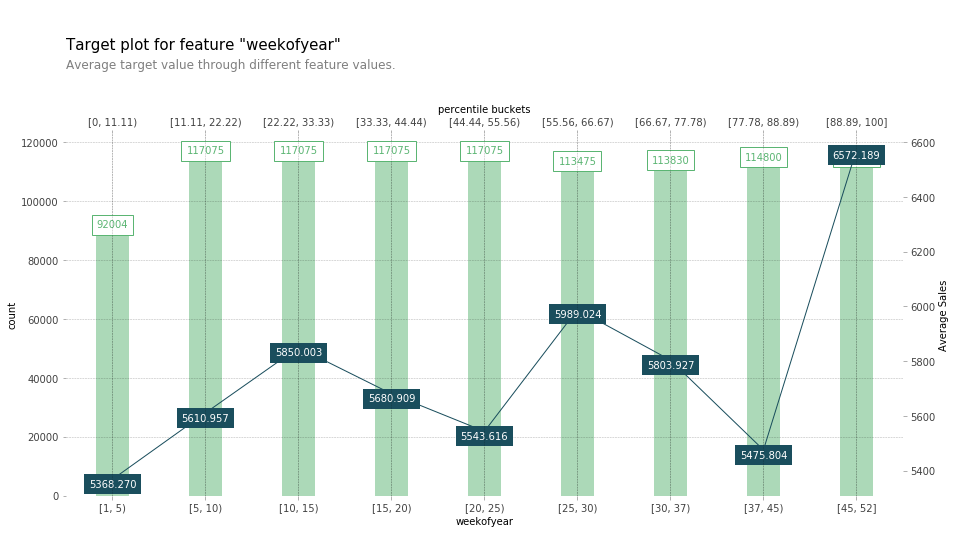

In [19]:
fig, axes, summary_df = info_plots.target_plot(
    df=ross_data, feature='weekofyear', feature_name='weekofyear', target=ross_target, show_percentile=True
)

In [20]:
summary_df

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,Sales
0,0,"[1, 5)",1.0,5.0,"[0, 11.11)",0.00,11.11,92004,5368.270303
1,1,"[5, 10)",5.0,10.0,"[11.11, 22.22)",11.11,22.22,117075,5610.957292
2,2,"[10, 15)",10.0,15.0,"[22.22, 33.33)",22.22,33.33,117075,5850.003049
3,3,"[15, 20)",15.0,20.0,"[33.33, 44.44)",33.33,44.44,117075,5680.908794
4,4,"[20, 25)",20.0,25.0,"[44.44, 55.56)",44.44,55.56,117075,5543.615947
5,5,"[25, 30)",25.0,30.0,"[55.56, 66.67)",55.56,66.67,113475,5989.024252
6,6,"[30, 37)",30.0,37.0,"[66.67, 77.78)",66.67,77.78,113830,5803.927040
7,7,"[37, 45)",37.0,45.0,"[77.78, 88.89)",77.78,88.89,114800,5475.804042
8,8,"[45, 52]",45.0,52.0,"[88.89, 100]",88.89,100.00,114800,6572.188763


## 3.2 check prediction distribution through feature 'weekofyear'

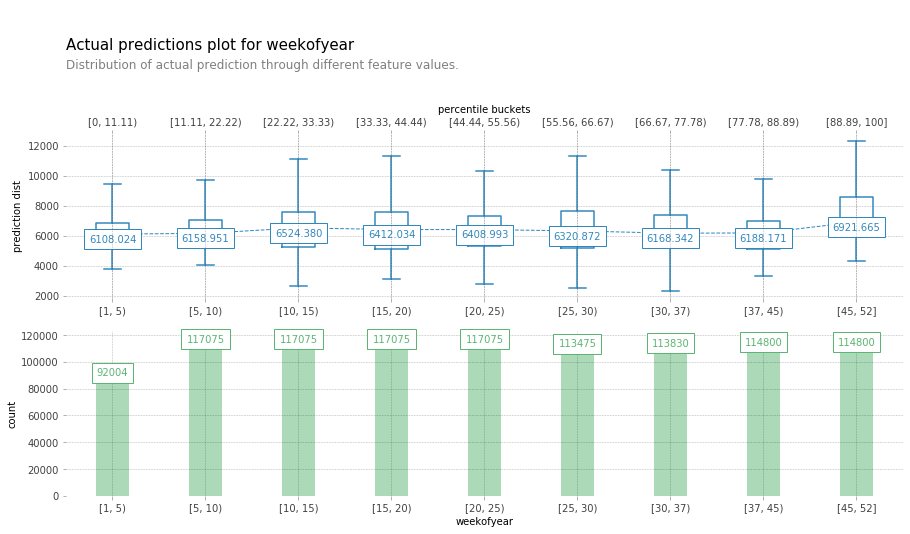

In [21]:
fig, axes, summary_df = info_plots.actual_plot(
    model=ross_model, X=ross_data[ross_features], feature='weekofyear', feature_name='weekofyear', 
    show_percentile=True
)

In [22]:
summary_df

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,"[1, 5)",1.0,5.0,"[0, 11.11)",0.00,11.11,92004,5126.222028,6108.023660,6859.026084
1,1,"[5, 10)",5.0,10.0,"[11.11, 22.22)",11.11,22.22,117075,5203.739661,6158.951422,7016.036574
2,2,"[10, 15)",10.0,15.0,"[22.22, 33.33)",22.22,33.33,117075,5225.379583,6524.379953,7603.238395
3,3,"[15, 20)",15.0,20.0,"[33.33, 44.44)",33.33,44.44,117075,5117.850950,6412.034492,7606.530350
4,4,"[20, 25)",20.0,25.0,"[44.44, 55.56)",44.44,55.56,117075,5299.103355,6408.992568,7305.690330
5,5,"[25, 30)",25.0,30.0,"[55.56, 66.67)",55.56,66.67,113475,5213.326249,6320.871761,7669.668527
6,6,"[30, 37)",30.0,37.0,"[66.67, 77.78)",66.67,77.78,113830,5333.095216,6168.342238,7377.733277
7,7,"[37, 45)",37.0,45.0,"[77.78, 88.89)",77.78,88.89,114800,5146.133193,6188.171140,7000.344530
8,8,"[45, 52]",45.0,52.0,"[88.89, 100]",88.89,100.00,114800,6007.616053,6921.665400,8549.194791


## 3.3 pdp for feature 'weekofyear'

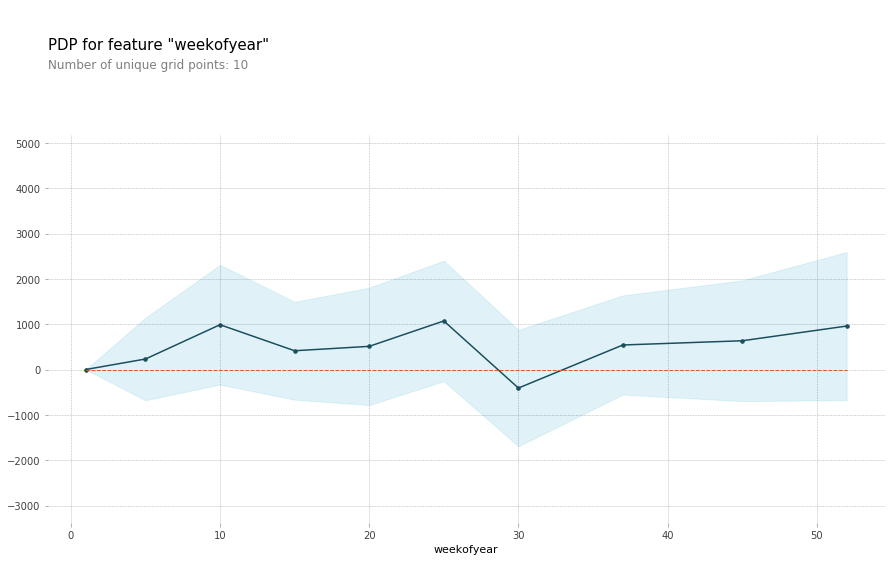

In [23]:
pdp_weekofyear = pdp.pdp_isolate(
    model=ross_model, dataset=ross_data, model_features=ross_features, feature='weekofyear'
)
fig, axes = pdp.pdp_plot(pdp_weekofyear, 'weekofyear')

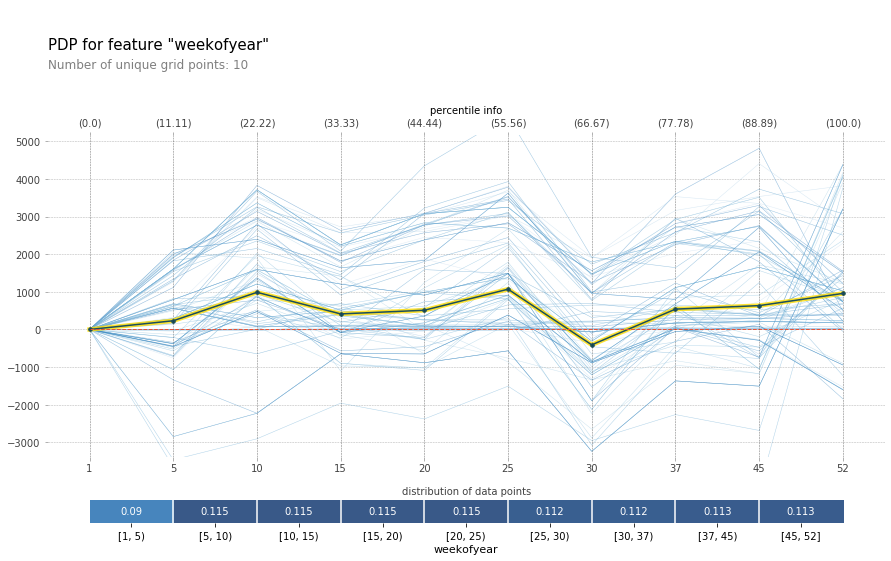

In [24]:
fig, axes = pdp.pdp_plot(
    pdp_weekofyear, 'weekofyear', plot_lines=True, frac_to_plot=100, x_quantile=True, 
    plot_pts_dist=True, show_percentile=True
)

# 4. Interaction between two variables: weekofyear and StoreType

## 4.1 target distribution through feature combination of 'weekofyear' and 'StoreType'

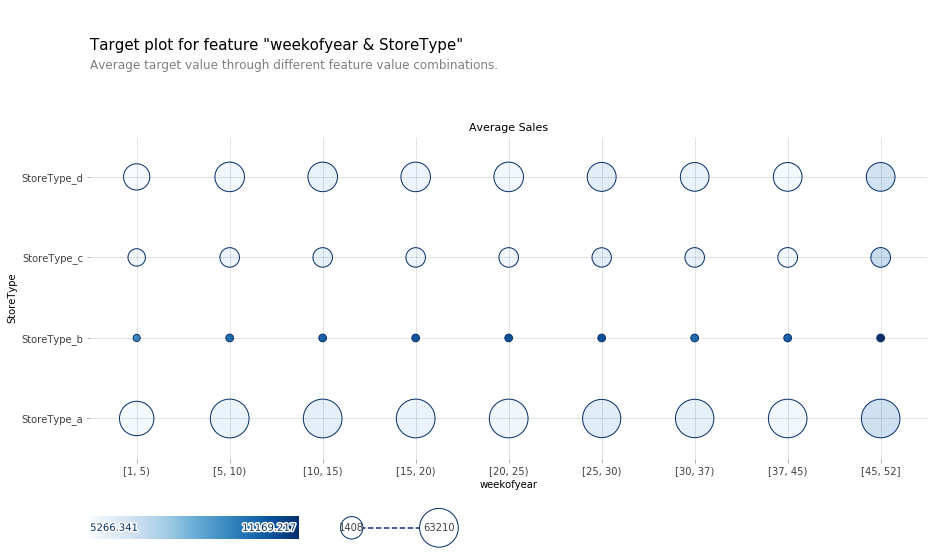

In [25]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=ross_data, features=['weekofyear', ['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']], 
    feature_names=['weekofyear', 'StoreType'], target=ross_target
)

In [26]:
summary_df.head()

,x1,x2,display_column_1,display_column_2,value_lower_1,value_upper_1,count,Sales
0,0,0,"[1, 5)",StoreType_a,1.0,5.0,49713,5328.094422
1,0,1,"[1, 5)",StoreType_b,1.0,5.0,1408,9024.250000
2,0,2,"[1, 5)",StoreType_c,1.0,5.0,12242,5349.400506
3,0,3,"[1, 5)",StoreType_d,1.0,5.0,28641,5266.341189
4,1,0,"[5, 10)",StoreType_a,5.0,10.0,63210,5592.353805


## 4.2 prediction distribution through feature combination of 'weekofyear' and 'StoreType'

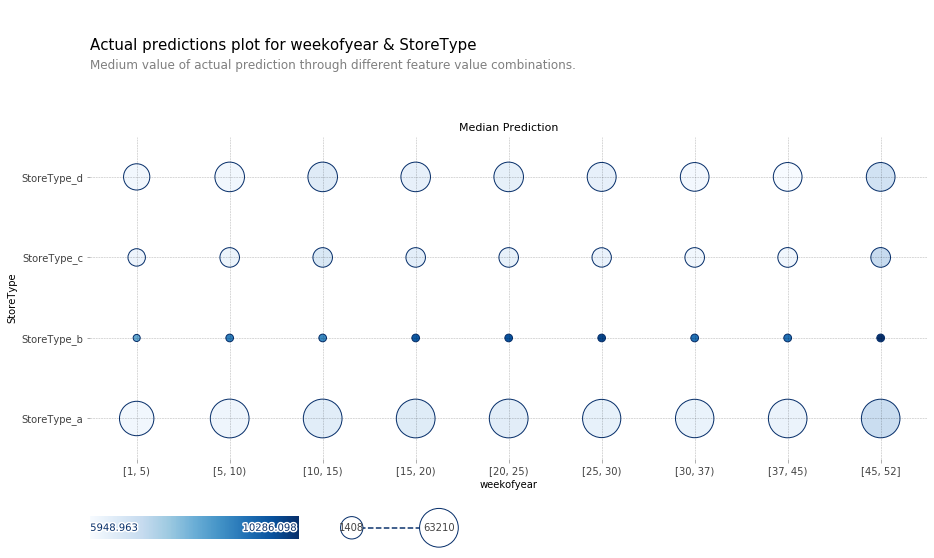

In [27]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=ross_model, X=ross_data[ross_features], 
    features=['weekofyear', ['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']], 
    feature_names=['weekofyear', 'StoreType']
)

In [28]:
summary_df.head()

,x1,x2,display_column_1,display_column_2,value_lower_1,value_upper_1,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,0,"[1, 5)",StoreType_a,1.0,5.0,49713,4590.550463,6100.417801,6947.505857
1,0,1,"[1, 5)",StoreType_b,1.0,5.0,1408,7327.157241,8202.251118,10313.694804
2,0,2,"[1, 5)",StoreType_c,1.0,5.0,12242,5524.695961,6184.785034,6712.998961
3,0,3,"[1, 5)",StoreType_d,1.0,5.0,28641,5273.600699,6090.326576,6550.324183
4,1,0,"[5, 10)",StoreType_a,5.0,10.0,63210,5234.421814,6158.951422,7016.036574


## 4.3 pdp for feature combination of 'weekofyear' and 'StoreType'

In [29]:
%%time
inter_rf = pdp.pdp_interact(
    model=ross_model, dataset=ross_data, model_features=ross_features, 
    features=['weekofyear', ['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']]
)

CPU times: user 3min 28s, sys: 15.8 s, total: 3min 44s
Wall time: 1min 33s


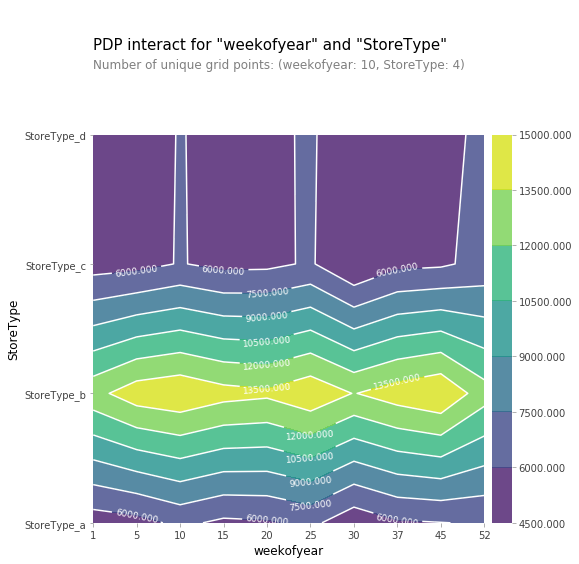

In [30]:
fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['weekofyear', 'StoreType'], x_quantile=True, plot_type='contour', plot_pdp=False
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


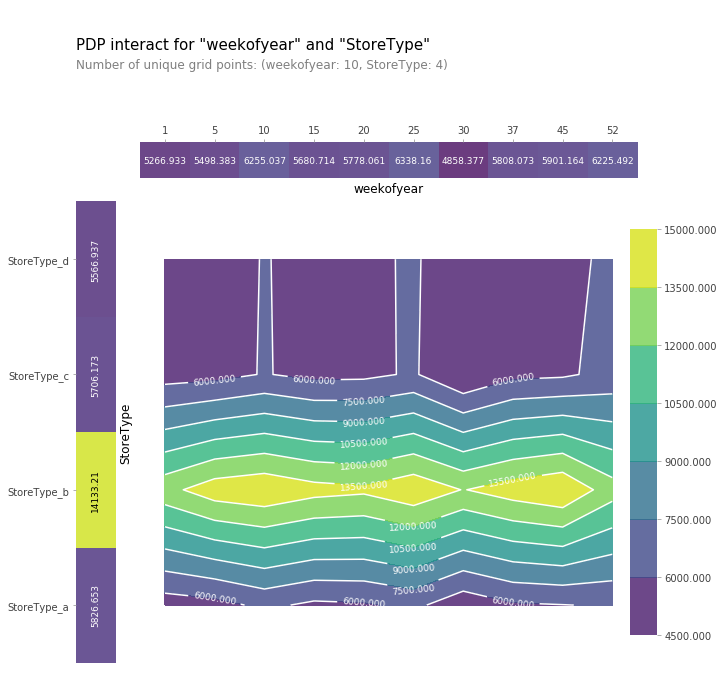

In [31]:
fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['weekofyear', 'StoreType'], x_quantile=True, plot_type='contour', plot_pdp=True
)

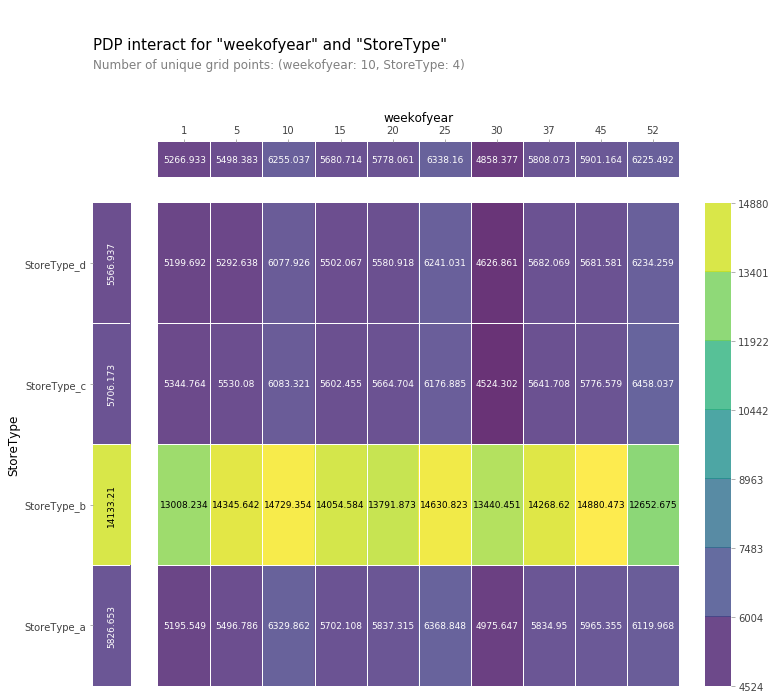

In [32]:
fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['weekofyear', 'StoreType'], x_quantile=True, plot_type='grid', plot_pdp=True
)